In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

In [2]:
!pip install scipy

In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00


In [4]:
from pmdarima.arima import auto_arima
from xgboost import XGBRegressor

In [5]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Series Temporais/energy.xlsx', index_col="DATE", parse_dates=True)

In [ ]:
df.head()

,energy
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 408 entries, 1985-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  408 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB


In [ ]:
df.shape

(408, 1)

In [ ]:
df.describe()

,energy
count,408.000000
mean,88.062232
std,15.168540
min,54.616500
25%,76.499750
50%,88.940450
75%,99.733200
max,126.362600


In [7]:
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [8]:
df.columns = ['producao']

<Axes: xlabel='DATE'>

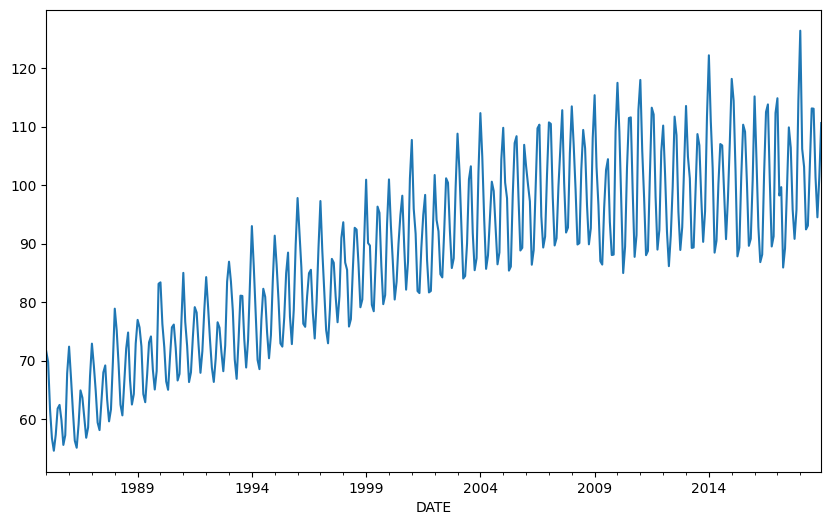

In [9]:
df['producao'].plot(figsize=(10,6))
# Olhando para essa dispersão podemos ver que existe uma tendencia da elevação do valores conforme o tempo
# Parece que existe uma sazonalidade em vista

Decompozição sazonal

<Figure size 800x600 with 0 Axes>

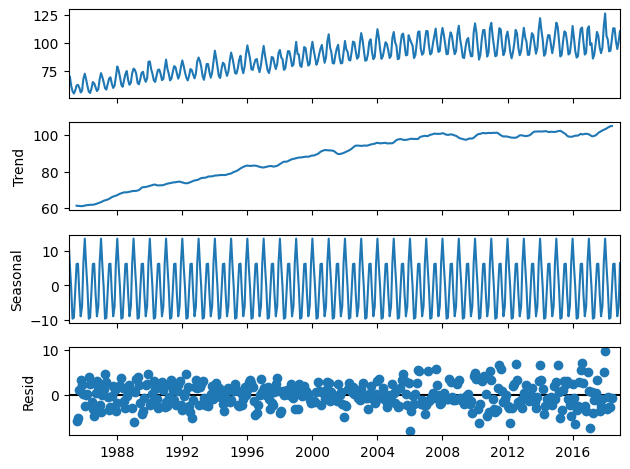

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df)

# Plotando o gráfico
fig = plt.figure(figsize=(8,6))

fig = resultado.plot()

# Podemos perceber através disso que temos muito uma tendencia e sasonalidade

# Um desvio padrão maior ao final dos anos

## Testes de estacionariedade

Uma série de testes para ver se essa série é estacionada ou tem sasonalidade

Se p valor maior que 5% = hipótese nula é verdadeira = não há sazonalidade

In [11]:
# Vamos verificar o valor do P valor

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['producao'].dropna())
print(f'Teste ADF: {result[0]}')
print(f'Teste ADF: {result[1]}')

# Nota-se que nosso p-valor deu maior que 5%, então nossa série não é estacionária, a hipótese nula é verdadeira

Teste ADF: -2.252399047046594
Teste ADF: 0.18777984601967806


In [12]:
df.head()

,producao
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [13]:
# Valor de baixo subtraindo o de cima
df.diff().head()

,producao
DATE,
1985-01-01,NaN
1985-02-01,-1.8050
1985-03-01,-8.1080
1985-04-01,-4.9311
1985-05-01,-2.1314


In [14]:
# Teste para ver se a diferença entre o dia atual e dia anterior e ver se essa diferença vai ser uma séria estacionária
# .diff


from statsmodels.tsa.stattools import adfuller

result = adfuller(df['producao'].diff().dropna())
print(f'Teste ADF: {result[0]}')
print(f'Teste ADF: {result[1]}')

# Agora podemos rejeitar a hipótese nula, a série é sim estacionária. Porque nosso número, em notação científica,  temos um valor muito menor que 5%

Teste ADF: -7.450892277526341
Teste ADF: 5.67456995585561e-11


### Escolhendo os melhores parametros para colocar dentro do ARIMA

In [15]:
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal=True,
                       m=6,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       information_criterion="aic",
                       trace=True,
                       error_action="ignore",
                       stepwise=True)

# Quanto menor o AIC melhor

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1968.148, Time=1.14 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2494.965, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2053.701, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2128.799, Time=0.40 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2064.883, Time=1.13 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=1.17 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1928.298, Time=2.59 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=2.20 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=1868.200, Time=7.45 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=1866.400, Time=4.60 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2014.153, Time=1.86 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=1916.488, Time=3.22 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=1936.850, Time=2.44 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=1868.120, Time=3.12 sec
 ARIMA(1,1,2)(1,1,2)[6]             : AIC=1

### Treinando o modelo

In [16]:
# Melhor modelo o Arima, P,q e d 1
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(1,1,1), seasonal_order=(1,1,2,6))
resultado_sarimax = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
resultado_sarimax.summary()

# Plotando algumas estatisticas

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                               producao   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Mon, 29 Jan 2024   AIC                           1866.400
Time:                                        13:27:54   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.055      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.180      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# Tirando o nosso predict
# Start = quantos dias para traz

predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [19]:
# Analisando o intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limite_abaixo = intervalo_confianca.iloc[:,0]
limite_acima = intervalo_confianca.iloc[:,1]

limite_abaixo[0], limite_acima[0]

# Temos esse intervalo de confiança, e é dentro desse range que temos os 95% de confiança dos resultados ai dentro estarem de acordo

(115.1447404570401, 124.45517675290846)

In [20]:
predicao_media[0]

119.79995860497428

## Predicao

In [21]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

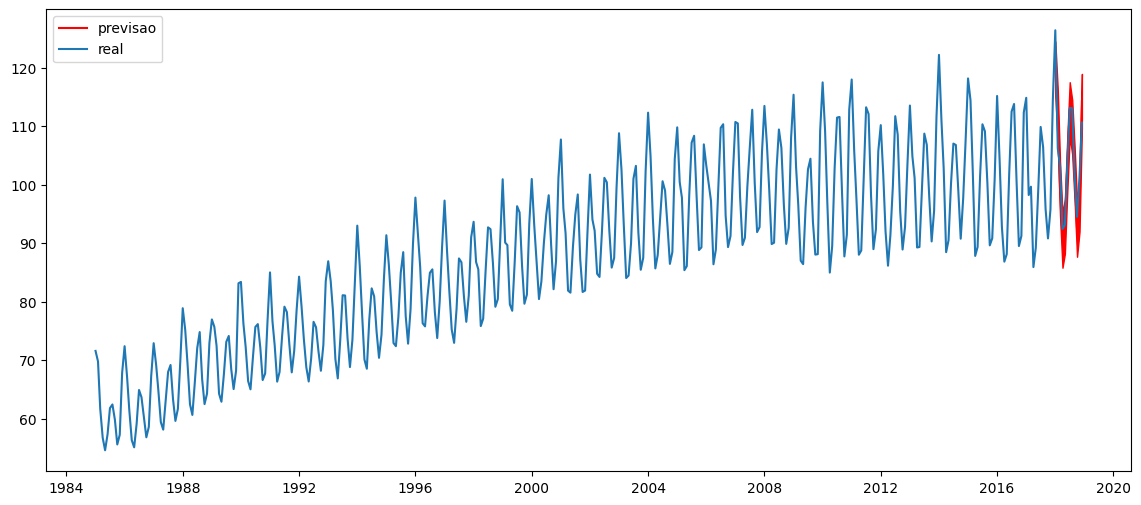

In [22]:
plt.figure(figsize=(14,6)),
plt.plot(datas_previsao, predicao_media.values, color='red', label='previsao')

plt.fill_between(datas_previsao, limite_abaixo, limite_acima, color='red')
plt.plot(datas, df.values, label= 'real')
plt.legend()
plt.show()

Vsito que o modelo conseguiu muito bem prever tanto a sasonalidade quanto a tendencia

In [23]:
# Metricas da analise
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df[-12:].values, predicao_media.values)
print(mae)

2.7071201498891306


## Prevendo o futuro

In [24]:
# Prevendo 12 dias para frente
forcast = resultado_sarimax.get_forecast(steps=12)
forcast_medio = forcast.predicted_mean
forcast_medio.size

12

In [25]:
intervalo_confianca_forcast = forcast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forcast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forcast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(91.38813005236821, 103.10930985132882)

In [26]:
forcast_medio[10]

97.24871995184851

In [27]:
# Prevendo
datas_forcast = np.asarray(forcast_medio.index)
pred_datas = np.asarray(predicao_media.index)


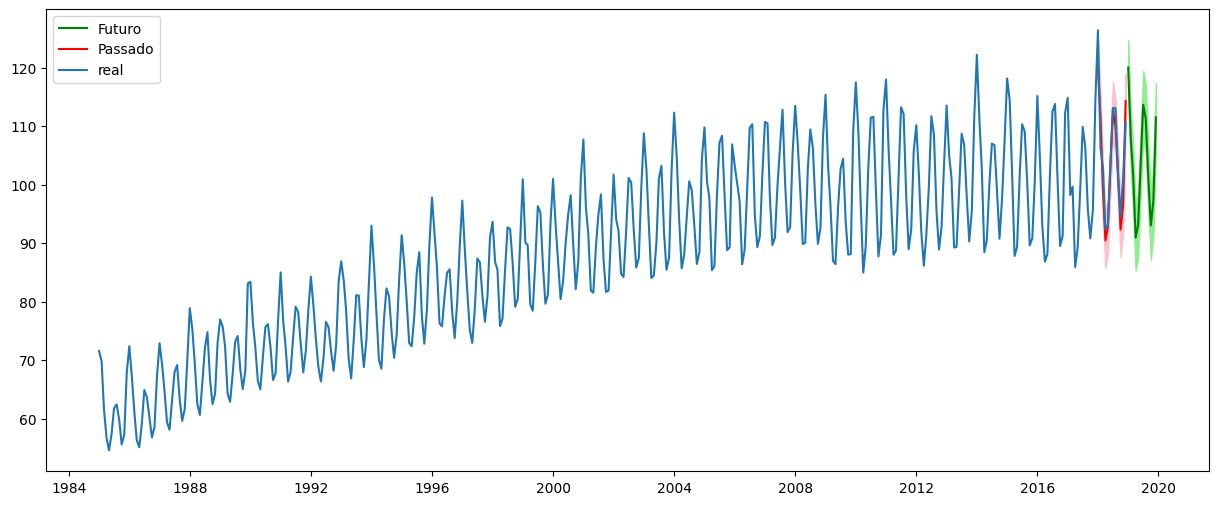

In [28]:
dates = np.asarray(df.index)
plt.figure(figsize=(15,6))
plt.plot(datas_forcast, forcast_medio.values, color='green', label='Futuro')
plt.fill_between(datas_forcast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao, predicao_media.values, color='red', label='Passado')
plt.fill_between(datas_previsao, limite_abaixo, limite_acima, color='pink')

plt.plot(dates, df.values, label='real')
plt.legend(loc='upper left')
plt.show()

# Continuando nosso modelo que usou o Arima para realizar o machine learning

In [29]:
from xgboost import XGBRegressor

In [30]:
treino = df.loc[df.index < '2016-12-31']
validacao =df.loc[df.index >'2016-12-31']

treino.shape, validacao.shape

((384, 1), (24, 1))

In [31]:
treino.head()

,producao
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [32]:
# Como o machine learing tem a limitação de que ele não sabe dizer que dia vem depois do outro
# Vamos tentar então prever o dia de amanhâ, mesmo sabendo desse detalhe

treino['target'] = treino['producao'].shift(-1)
treino.head()

<ipython-input-32-f2ca2de60869>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino['producao'].shift(-1)


,producao,target
DATE,,
1985-01-01,71.5920,69.7870
1985-02-01,69.7870,61.6790
1985-03-01,61.6790,56.7479
1985-04-01,56.7479,54.6165
1985-05-01,54.6165,57.3509


In [33]:
treino.dropna(inplace=True)

<ipython-input-33-b8dd0b7f87ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino.dropna(inplace=True)


In [35]:
validacao['target'] = validacao['producao'].shift(-1)
validacao.head()

<ipython-input-35-3dbab6a73b1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao['target'] = validacao['producao'].shift(-1)


,producao,target
DATE,,
2017-01-01,114.8282,98.2191
2017-02-01,98.2191,99.6408
2017-03-01,99.6408,85.9106
2017-04-01,85.9106,89.2053
2017-05-01,89.2053,99.1945


In [36]:
validacao.dropna(inplace= True)

<ipython-input-36-e11f433691fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao.dropna(inplace= True)


In [39]:
x_treino = treino.loc[:,['producao']].values
y_treino = treino.loc[:, ['target']].values

x_validacao = validacao.loc[:, ['producao']].values
y_validacao = validacao.loc[:, ['target']].values

In [41]:
modelo_xgba = XGBRegressor()
modelo_xgba.fit(x_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Conferindo e realizando a predicao

In [42]:
validacao.iloc[0]

producao    114.8282
target       98.2191
Name: 2017-01-01 00:00:00, dtype: float64

In [44]:
predicao = modelo_xgba.predict(x_validacao)
predicao

array([103.05468 ,  89.6212  , 108.89758 ,  79.16283 ,  93.78335 ,
        99.628296, 101.583725, 110.23003 , 106.858765,  98.68999 ,
       106.858765, 103.05468 , 110.27728 ,  97.96312 , 103.55588 ,
        96.872536,  86.97877 , 105.77548 , 114.146774, 114.146774,
       111.32476 ,  97.687325, 111.32476 ], dtype=float32)

In [46]:
validacao['pred'] = predicao
validacao.head()
# Vendo o quanto erramos

<ipython-input-46-4cec124e5ce0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao['pred'] = predicao


,producao,target,pred
DATE,,,
2017-01-01,114.8282,98.2191,103.054680
2017-02-01,98.2191,99.6408,89.621201
2017-03-01,99.6408,85.9106,108.897583
2017-04-01,85.9106,89.2053,79.162827
2017-05-01,89.2053,99.1945,93.783348


In [47]:
# Criando metricas
mean_absolute_error(x_validacao, predicao)

6.86671642747962

Visto que a performance foi um pouco inferior que o Arima